## 1. Import necessary libraries and read file. 

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import certifi
import ssl
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

data_train = pd.read_csv('../data/BBC News Train.csv')
data_test = pd.read_csv('../data/BBC News Test.csv')
data_sample_solution = pd.read_csv('../data/BBC News Sample Solution.csv')

## 2. Exploring and Visualizing the Data

Purpose: This section provides an initial exploration of the data and visualizes its distribution.

In [51]:
data_train.head()


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [52]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [53]:
data_train["Category"].value_counts()

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

Data_test information are as below: 

In [54]:
data_test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [55]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


Visualization for data_train:

(array([336.,   0., 261.,   0.,   0., 274.,   0., 346.,   0., 273.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

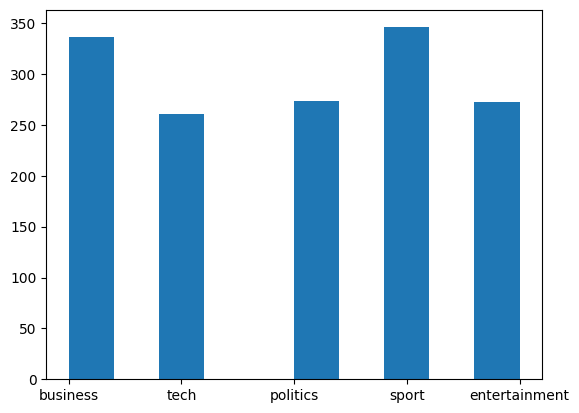

In [56]:
plt.hist(data_train["Category"])

## 3. Setting Up NLP Preprocessing

Purpose: This section prepares the text data for analysis by removing stopwords, tokenizing, and stemming.

In [57]:
ssl._create_default_https_context = ssl._create_unverified_context
nltk.data.path.append(certifi.where())
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/bopang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bopang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
translator = str.maketrans('', '', string.punctuation)

## 4. Text Preprocessing Function

Purpose: This section defines a function to preprocess the text data by tokenizing, removing stopwords, and stemming the words.

In [59]:
def preprocessDataset(train_text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(train_text)
    words = [word for word in words if not word in stop_words]
    stemmer= PorterStemmer()
    stem_text=' '.join([stemmer.stem(word.translate(translator)) for word in words])
    return stem_text

In [60]:
preprocessDataset(data_train.iloc[0].Text)

'worldcom exboss launch defenc lawyer defend former worldcom chief berni ebber batteri fraud charg call compani whistleblow first wit  cynthia cooper worldcom exhead intern account alert director irregular account practic us telecom giant 2002 warn led collaps firm follow discoveri  11bn  £57bn  account fraud  mr ebber plead guilti charg fraud conspiraci  prosecut lawyer argu mr ebber orchestr seri account trick worldcom order employe hide expens inflat revenu meet wall street earn estim  ms cooper run consult busi told juri new york wednesday extern auditor arthur andersen approv worldcom account earli 2001 2002 said andersen given green light procedur practic use worldcom  mr ebber lawyer said unawar fraud argu auditor alert problem  ms cooper also said sharehold meet mr ebber often pass technic question compani financ chief give brief answer  prosecut star wit former worldcom financi chief scott sullivan said mr ebber order account adjust firm tell hit book  howev ms cooper said mr 

In [61]:
data_train.iloc[0].Text

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

## 5. Applying Preprocessing to the Entire Dataset

Purpose: This section applies the text preprocessing function to the entire dataset.

In [62]:
data_train['TextCleaned'] = data_train['Text'].apply(preprocessDataset)

In [63]:
data_train['TextCleaned']

0       worldcom exboss launch defenc lawyer defend fo...
1       german busi confid slide german busi confid fe...
2       bbc poll indic econom gloom citizen major nati...
3       lifestyl govern mobil choic faster better funk...
4       enron boss  168m payout eighteen former enron ...
                              ...                        
1485    doubl evict big brother model capric holbi cit...
1486    dj doubl act revamp chart show dj duo jk joel ...
1487    weak dollar hit reuter revenu media group reut...
1488    appl ipod famili expand market appl expand ipo...
1489    santi worm make unwelcom visit thousand websit...
Name: TextCleaned, Length: 1490, dtype: object

## 6. Feature Extraction Using TF-IDF

Purpose: This section converts the cleaned text data into numerical features using the TF-IDF vectorizer.

In [64]:
vect = TfidfVectorizer()
X = vect.fit_transform(data_train.TextCleaned)
X
X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02407628, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02546556, 0.        , ..., 0.        , 0.        ,
        0.        ]])

## 7. Topic Modeling Using NMF

Purpose: This section applies Non-negative Matrix Factorization (NMF) to identify topics within the text data.

In [65]:
# set n_components=5 for the 5 categories to classify
model = NMF(n_components=5, random_state=42)
W = model.fit_transform(X)
H = model.components_
W.shape

(1490, 5)

In [66]:
H.shape

(5, 19645)

In [67]:
W

array([[6.92692014e-04, 4.07263255e-02, 1.24470770e-02, 5.30154711e-03,
        5.88158134e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.14560228e-01],
       [1.47048247e-02, 3.34845561e-02, 2.23136449e-02, 0.00000000e+00,
        1.21383956e-01],
       ...,
       [8.27934717e-03, 0.00000000e+00, 1.19923608e-04, 8.25323565e-03,
        1.60985809e-01],
       [0.00000000e+00, 0.00000000e+00, 2.18646066e-01, 1.38263954e-02,
        2.41925381e-02],
       [0.00000000e+00, 0.00000000e+00, 1.15825008e-01, 0.00000000e+00,
        0.00000000e+00]])

## 8. Assigning Labels Based on NMF Topics

Purpose: This section assigns predicted labels to the text data based on the topics identified by the NMF model.

In [68]:
predicted_label = np.squeeze(np.asarray(W.argmax(axis=1)))
predicted_label

array([4, 4, 4, ..., 4, 2, 2])

In [69]:
predicted_label.shape

(1490,)

In [70]:
type(predicted_label)

numpy.ndarray

## 9. Mapping Predicted Labels to Categories

Purpose: This section maps the predicted labels to the original categories.

In [71]:
label_to_categ = {}
for i in range(5):
    label_to_categ[i] = data_train.iloc[np.where(predicted_label == i)[0]]['Category'].value_counts().idxmax()
label_to_categ

{0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}

## 10. Evaluating the Model

Purpose: This section evaluates the performance of the model using the training dataset.

In [72]:
predicted_categ = np.vectorize(label_to_categ.get)(predicted_label)
predicted_categ

array(['business', 'business', 'business', ..., 'business', 'tech',
       'tech'], dtype='<U13')

In [73]:
accuracy_score(data_train.Category, predicted_categ)

0.9194630872483222

In [74]:
confusion_matrix(data_train.Category, predicted_categ)

array([[312,   1,  13,   0,  10],
       [ 10, 226,   6,   3,  28],
       [ 18,   0, 249,   3,   4],
       [  2,   4,   0, 340,   0],
       [  4,   6,   3,   5, 243]])


## 11. Predicting and Storing Test Data Results
Purpose: This section applies the trained model to the test dataset and saves the predictions.

In [75]:
test_pred_categ = np.vectorize(label_to_categ.get)(
    model.transform(vect.transform(
        data_test['Text'].apply(preprocessDataset))).argmax(axis=1))


In [76]:
type(test_pred_categ)

numpy.ndarray

In [77]:
test_pred_categ.shape

(735,)

In [78]:
data_test['Category'] = test_pred_categ

In [79]:
data_test

,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport
...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,business
731,373,u2 to play at grammy awards show irish rock ba...,entertainment
732,1704,sport betting rules in spotlight a group of mp...,tech
733,206,alfa romeos to get gm engines fiat is to sto...,business


In [80]:
data_test.drop(['Text'], axis = 1).to_csv('submission.csv', index = False)

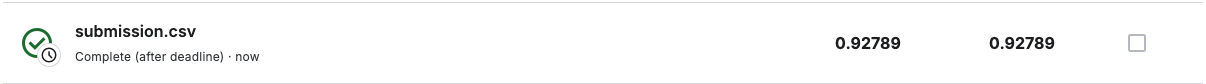

In [81]:
from IPython.display import Image
Image(filename='Untitled.png') 